# 🧬 Species Location Metadata
**Author:** Minoli Daigavane  
**Date:** 2024-09-22

This notebook extracts, processes, and visualizes geographic location metadata for vertebrate genome assemblies. It:

- Parses NCBI `.jsonl` files
- Geocodes sampling locations
- Cleans and merges metadata
- Generates global and regional maps


In [4]:
# load required packages
library(jsonlite)
library(dplyr)
library(purrr)
library(tidyr)
library(ggplot2)
library(maps)
library(ggmap)
library(tidygeocoder)
library(pals)
library(sf) 
library(rworldmap)
library(rnaturalearth)
library(tidyverse)
library(forcats)
library(readr)
library(cowplot)

In [5]:
# read in NCBI metadata files and expand any nested fields.

metadata_dir <- "../metadata"
jsonl_files <- list.files(path = metadata_dir, pattern = "assembly_data_report.jsonl", recursive = TRUE, full.names = TRUE)

read_jsonl_file <- function(f) {
  json_data <- stream_in(file(f))
  return(json_data)
}
metadata <- suppressMessages(do.call(bind_rows, lapply(jsonl_files, read_jsonl_file)))

expand_and_prefix_recursively <- function(df) {
  repeat {
    nested_cols <- sapply(df, is.data.frame)
    if (!any(nested_cols)) break
    
    df <- df %>%
      mutate(across(where(is.data.frame), 
                    ~ setNames(., paste0(cur_column(), "_", names(.))))) %>%
      unnest(cols = where(is.data.frame), keep_empty = TRUE)
  }
  return(df)
}

 Imported 1 records. Simplifying...
 Imported 1 records. Simplifying...
 Imported 1 records. Simplifying...
 Imported 1 records. Simplifying...
 Imported 1 records. Simplifying...
 Imported 1 records. Simplifying...
 Imported 1 records. Simplifying...
 Imported 1 records. Simplifying...
 Imported 1 records. Simplifying...
 Imported 1 records. Simplifying...
 Imported 1 records. Simplifying...
 Imported 1 records. Simplifying...
 Imported 1 records. Simplifying...
 Imported 1 records. Simplifying...
 Imported 1 records. Simplifying...
 Imported 1 records. Simplifying...
 Imported 1 records. Simplifying...
 Imported 1 records. Simplifying...
 Imported 1 records. Simplifying...
 Imported 1 records. Simplifying...
 Imported 1 records. Simplifying...
 Imported 1 records. Simplifying...
 Imported 1 records. Simplifying...
 Imported 1 records. Simplifying...
 Imported 1 records. Simplifying...
 Imported 1 records. Simplifying...
 Imported 1 records. Simplifying...
 Imported 1 records. Simplif

In [6]:
# combine NCBI metadata with previous metadata files
ncbi_metadata <- expand_and_prefix_recursively(metadata) %>% 
  select(
    accession,
    assemblyInfo_biosample_geoLocName,
    assemblyInfo_biosample_latLon,
    assemblyInfo_comments
  )

metadata_old <- read.table('../metadata/assembly_metadata_wide.tsv', sep='\t', header=T, quote = "") %>%
select(assembly_bio_sample_accession,
       scientific_name,
       assembly_id_pri,
       taxonomic_group)

combined_metadata <- metadata_old %>%
  left_join(ncbi_metadata, by = c("assembly_id_pri" = "accession")) %>%
  mutate(
    geo_location = assemblyInfo_biosample_geoLocName,
    latlon = assemblyInfo_biosample_latLon,
    taxonomic_group = fct_relevel(taxonomic_group, c("jawless fish", "cartilaginous fish", "ray-finned fish", "amphibian", "reptile", "bird", "mammal"))
  )

In [7]:
process_coordinates <- function(latLon, geoLocName) {
  if (!is.na(latLon)) {
    lat <- as.numeric(sub("([0-9.]+) [NS] .*", "\\1", latLon))
    if (grepl("S", latLon)) lat <- -lat
    
    lon <- as.numeric(sub(".* ([0-9.]+) [EW]", "\\1", latLon))
    if (grepl("W", latLon)) lon <- -lon
    
    return(list(lat = lat, lon = lon))
  } else if (!is.na(geoLocName)) {
    location_query <- sub(".*: ?(.*?),.*", "\\1", geoLocName)
    geocoded <- geo(address = location_query, method = "osm", limit = 1, quiet = TRUE)
    return(list(lat = geocoded$lat, lon = geocoded$long))
  } else {
    return(list(lat = NA, lon = NA))
  }
}

processed_metadata <- combined_metadata %>%
  rowwise() %>%
  mutate(
    coords = list(process_coordinates(latlon, geo_location)),
    lat = coords$lat,
    lon = coords$lon
  ) %>%
  ungroup() %>%
  select(-coords)

# Manually fix specific records
processed_metadata <- processed_metadata %>%
  mutate(
    lat = case_when(
      assembly_bio_sample_accession == "SAMN35075070" ~ 30.6187,
      assembly_bio_sample_accession == "SAMN23532249" ~ -1.2109,
      TRUE ~ lat
    ),
    lon = case_when(
      assembly_bio_sample_accession == "SAMN35075070" ~ -96.3365,
      assembly_bio_sample_accession == "SAMN23532249" ~ -48.2951,
      TRUE ~ lon
    )
  )


Warning message:
"A numeric `legend.position` argument in `theme()` was deprecated in ggplot2
3.5.0.
i Please use the `legend.position.inside` argument of `theme()` instead."


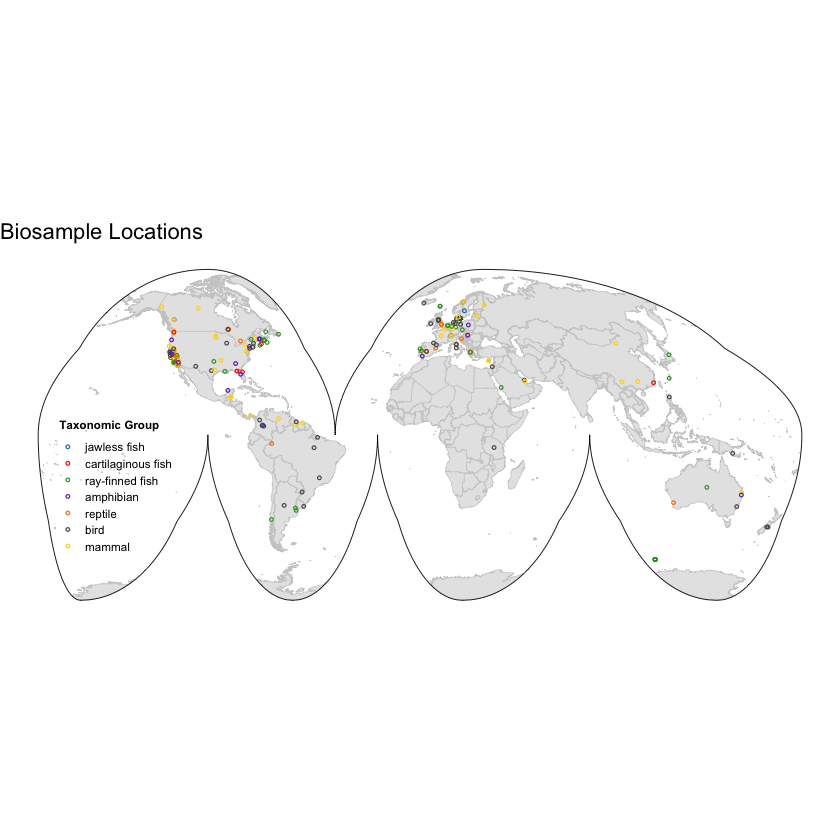

In [8]:
world_sf <- ne_countries(scale = 'medium', type = 'map_units',
                         returnclass = 'sf')

# projection outline in long-lat coordinates
lats <- c(
  90:-90, # right side down
  -90:0, 0:-90, # third cut bottom
  -90:0, 0:-90, # second cut bottom
  -90:0, 0:-90, # first cut bottom
  -90:90, # left side up
  90:0, 0:90, # cut top
  90 # close
)
longs <- c(
  rep(180, 181), # right side down
  rep(c(80.01, 79.99), each = 91), # third cut bottom
  rep(c(-19.99, -20.01), each = 91), # second cut bottom
  rep(c(-99.99, -100.01), each = 91), # first cut bottom
  rep(-180, 181), # left side up
  rep(c(-40.01, -39.99), each = 91), # cut top
  180 # close
)

goode_outline <- list(cbind(longs, lats)) %>%
  st_polygon() %>%
  st_sfc(crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

crs_goode <- "+proj=igh"
goode_outline <- st_transform(goode_outline, crs = crs_goode)

xlim <- st_bbox(goode_outline)[c("xmin", "xmax")] * 1.1
ylim <- st_bbox(goode_outline)[c("ymin", "ymax")] * 1.1

goode_encl_rect <- list(
  cbind(
    c(xlim[1], xlim[2], xlim[2], xlim[1], xlim[1]),
    c(ylim[1], ylim[1], ylim[2], ylim[2], ylim[1])
  )
) %>%
  st_polygon() %>%
  st_sfc(crs = crs_goode)

goode_without <- st_difference(goode_encl_rect, goode_outline)

location_data <- processed_metadata %>%
  mutate(lat = as.numeric(lat),
         lon = as.numeric(lon)) %>%
  drop_na(lat, lon)

location_sf <- st_as_sf(location_data, coords = c("lon", "lat"), crs = 4326)
location_sf <- st_transform(location_sf, crs = crs_goode)

goode_map <- ggplot() +
  geom_sf(data = st_transform(world_sf, crs = crs_goode), fill = "grey90", color = "grey80", linewidth = 0.2) +  # Restore country fill
  geom_sf(data = goode_without, fill = "white", color = NA) +  # White out outside
  geom_sf(data = location_sf, aes(color = taxonomic_group), size = 0.7, shape = 1) +
  geom_sf(data = goode_outline, fill = NA, color = "black", linewidth = 0.25) +
  coord_sf(crs = crs_goode, expand = FALSE) +
  theme_minimal() +
  theme(
    legend.position = c(.06, 0.57),
    legend.justification = c(0, 1),
    legend.background = element_rect(fill = NA, color = NA), 
    legend.text = element_text(size = 7),
    legend.title = element_text(size = 7, face = 'bold'),
    legend.key.size = unit(0.35, "cm"),
    legend.spacing.y = unit(-0.25, "cm"),
    panel.grid = element_blank(), 
    axis.text = element_blank(), 
    axis.ticks = element_blank(),
    panel.border = element_blank(),
    plot.margin = margin(0, 0, 0, 0),
    panel.spacing = unit(0, "pt")
  ) +
  guides(color = guide_legend(ncol = 1, byrow = TRUE)) +
  scale_color_manual(values = cols25(n=7)) +
  labs(title = "Biosample Locations", color = "Taxonomic Group")

goode_map

Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"
Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"
Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"
Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"


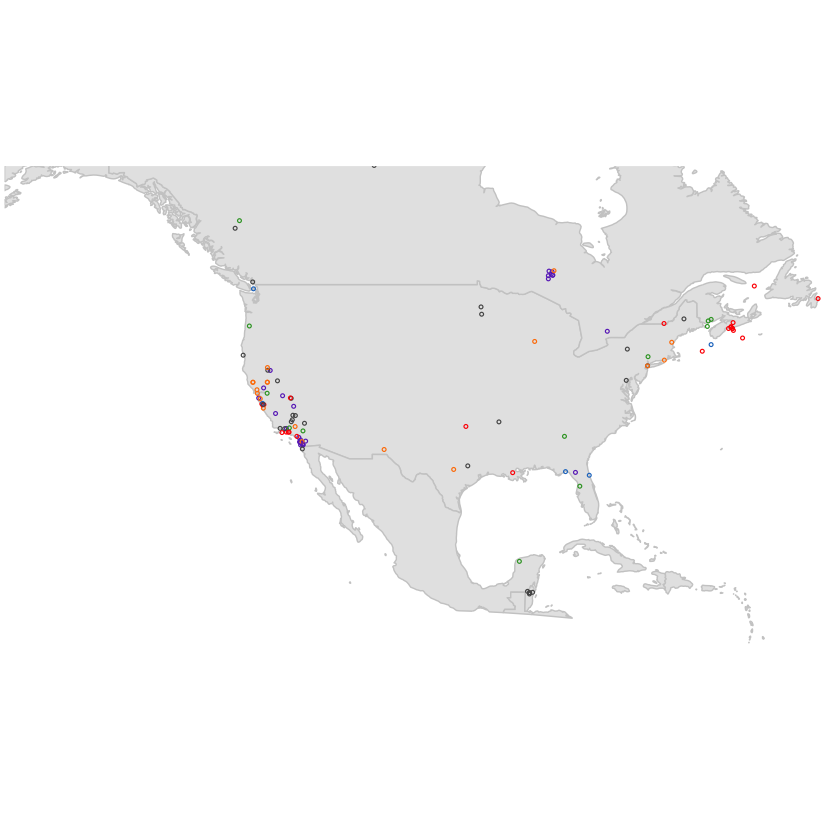

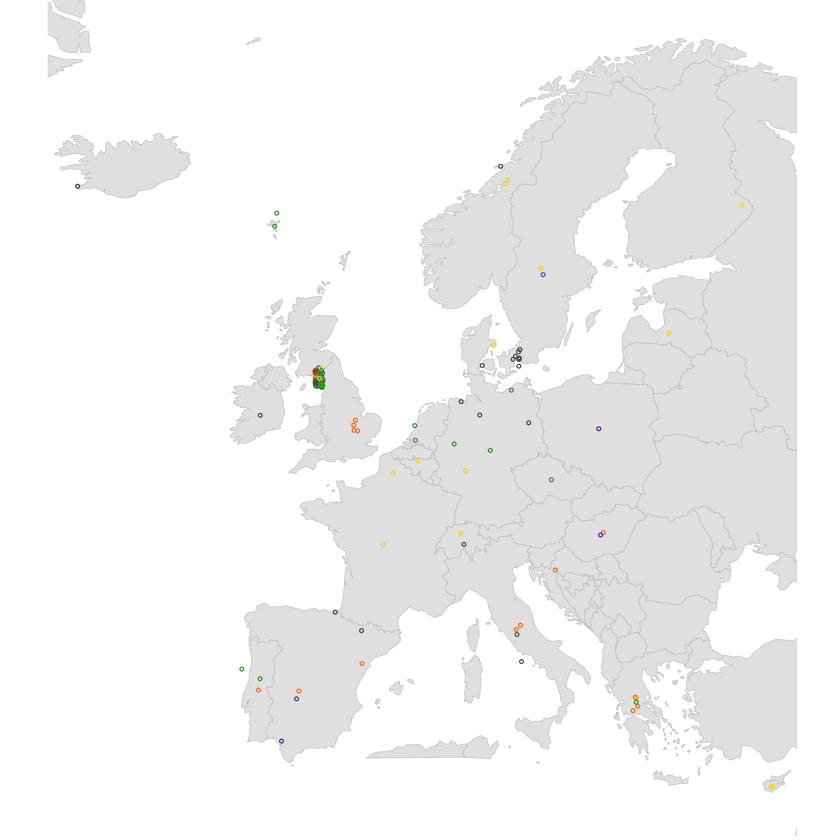

In [9]:
jitter_amount <- 0.5

world_sf <- st_transform(world_sf, crs = 4326)
location_sf <- st_transform(location_sf, crs = 4326)

na_bbox <- st_bbox(c(xmin = -154, xmax = -50, ymin = 10, ymax = 61), crs = st_crs(4326))
europe_bbox <- st_bbox(c(xmin = -25, xmax = 35, ymin = 32.5, ymax = 73), crs = st_crs(4326))

world_na <- st_crop(world_sf, na_bbox)
location_na <- st_crop(location_sf, na_bbox)

world_europe <- st_crop(world_sf, europe_bbox)
location_europe <- st_crop(location_sf, europe_bbox)

na_duplicate_points <- location_na %>%
  st_coordinates() %>%
  as.data.frame() %>%
  group_by(X, Y) %>%
  summarise(count = n(), .groups = "drop") %>%
  filter(count > 1)

location_na <- location_na %>%
  mutate(is_duplicate = paste0(st_coordinates(.)[,1], st_coordinates(.)[,2]) %in% 
           paste0(na_duplicate_points$X, na_duplicate_points$Y))

location_na_jittered <- location_na
location_na_jittered$geometry <- st_geometry(location_na$geometry)
location_na_jittered$geometry[location_na$is_duplicate] <- 
  st_jitter(location_na$geometry[location_na$is_duplicate], amount = jitter_amount)

euro_duplicate_points <- location_europe %>%
  st_coordinates() %>%
  as.data.frame() %>%
  group_by(X, Y) %>%
  summarise(count = n(), .groups = "drop") %>%
  filter(count > 1)

location_europe <- location_europe %>%
  mutate(is_duplicate = paste0(st_coordinates(.)[,1], st_coordinates(.)[,2]) %in% 
           paste0(euro_duplicate_points$X, euro_duplicate_points$Y))

location_europe_jittered <- location_europe
location_europe_jittered$geometry <- st_geometry(location_europe$geometry)
location_europe_jittered$geometry[location_europe$is_duplicate] <- 
  st_jitter(location_europe$geometry[location_europe$is_duplicate], amount = jitter_amount)


na_map_jittered <- ggplot() + 
  geom_sf(data = world_na, fill = "grey90", color = "grey80", linewidth = 0.4) + 
  geom_sf(data = location_na_jittered, aes(color = taxonomic_group), size = 0.75, shape = 1) +
  scale_color_manual(values = cols25(n = 7), name = "Taxonomic Group") +
  coord_sf(xlim = c(na_bbox$xmin, na_bbox$xmax),
           ylim = c(na_bbox$ymin, na_bbox$ymax),
           expand = FALSE) +
  theme_minimal() +
  theme(
    legend.position = "none",
    panel.spacing = unit(0, "pt"),
    plot.margin = margin(0, 0, 0, 0),
    title = element_text(size = 10),
    panel.grid = element_blank(),
    axis.text = element_blank(),
    axis.ticks = element_blank()
  )

europe_map_jittered <- ggplot() +
  geom_sf(data = world_europe, fill = "grey90", color = "grey80") +
  geom_sf(data = location_europe_jittered, aes(color = taxonomic_group), size = 0.75, shape = 1) +
  scale_color_manual(values = cols25(n=7), name = "Taxonomic Group") +
  coord_sf(xlim = c(europe_bbox$xmin, europe_bbox$xmax),
           ylim = c(europe_bbox$ymin, europe_bbox$ymax),
           expand = FALSE) +
  theme_minimal() +
  theme(
    legend.position = "none",
    panel.spacing = unit(0, "pt"),
    plot.margin = margin(0, 0, 0, 0),
    panel.grid = element_blank(),
    axis.text = element_blank(),
    axis.ticks = element_blank()
  )

na_map_jittered
europe_map_jittered

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Warning message in get_plot_component(plot, "guide-box"):
"Multiple components found; returning the first one. To return all, use `return_all = TRUE`."
Saving 7 x 7 in image


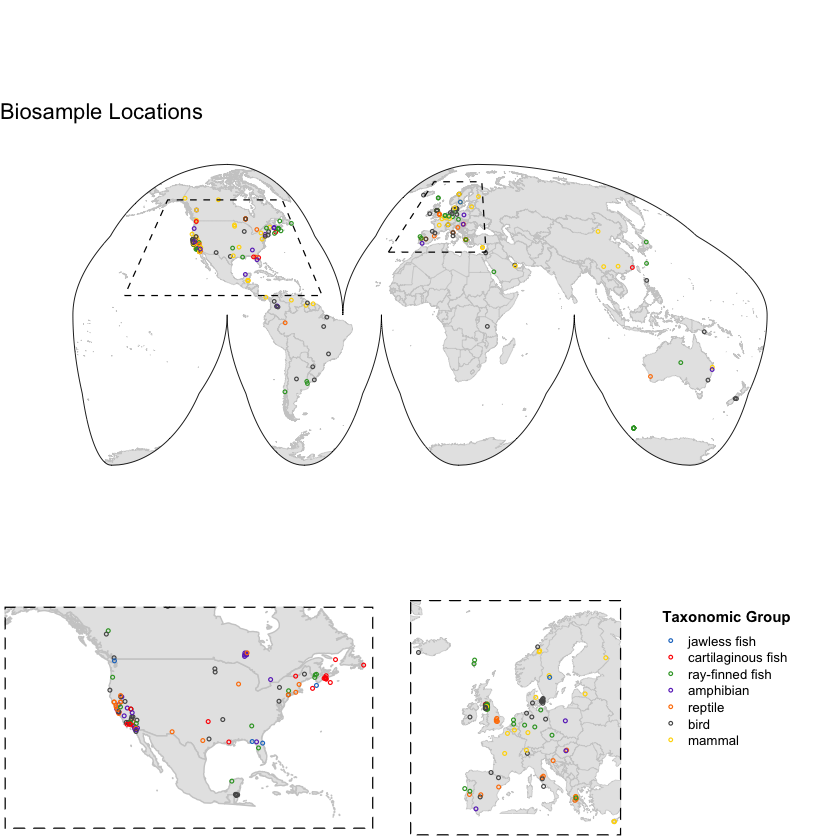

In [11]:
na_rect <- st_as_sfc(st_bbox(na_bbox), crs = st_crs(4326)) %>%
  st_transform(crs = crs_goode)

europe_rect <- st_as_sfc(st_bbox(europe_bbox), crs = st_crs(4326)) %>%
  st_transform(crs = crs_goode)

boxed_goode_map <- goode_map +
  geom_sf(data = na_rect, fill = NA, color = "black", linetype = 2, linewidth = 0.35) +
  geom_sf(data = europe_rect, fill = NA, color = "black", linetype = 2, linewidth = 0.35) +
  theme(legend.position = "none")

add_dashed_border <- function(plot) {
  plot +
    annotation_custom(
      grob = grid::rectGrob(gp = grid::gpar(col = "black", lty = "dashed", fill = NA, lwd = 2)),
      xmin = -Inf, xmax = Inf, ymin = -Inf, ymax = Inf
    ) +
    theme(plot.margin = margin(0, 0, 0, 0))
}

legend <- get_legend(
  goode_map +
    theme(legend.position = "right",
          legend.title = element_text(size = 9, face = "bold"),
          legend.text = element_text(size = 8))
)

na_map_jittered_boxed <- add_dashed_border(na_map_jittered)
europe_map_jittered_boxed <- add_dashed_border(europe_map_jittered)

inset_row <- plot_grid(
  na_map_jittered_boxed,
  europe_map_jittered_boxed,
  legend,
  ncol = 3,
  rel_widths = c(2, 1.5, 1),
  align = "v",
  axis = "tb"
)

final_map <- plot_grid(
  boxed_goode_map,
  inset_row,
  ncol = 1,
  rel_heights = c(5, 2)
)

final_map
ggsave("../plots/global_map.png")


In [ ]:
write.csv(processed_metadata, "files/location_data.csv")